In [2]:
import numpy as np
from backend.utils import *
from matplotlib.pyplot import plot
import torch
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr

This notebook contains the data generation classes

### Mesh Points

In [2]:
nx = 50 
nt = 500*2
dx = 0.1
dt = 0.01/2
D = 0.1 #diffusion coeff
sigma = 0.05

In [3]:
class DataModel:
    '''
    Just inherit this class to create your own data generator class
    '''
    def __init__(self,data_name,Nt,Nx,dt,dx,**kw):
        self.data_name = data_name
        self.Nt = Nt
        self.Nx = Nx
        self.dt = dt
        self.dx = dx
    
    @property
    def Lx(self):
        return self.dx*self.Nx
    
    @property
    def Lt(self):
        return self.dt*self.Nt
    
    def data(self):
        '''returns data
        '''
        raise NotImplementedError
        
    def _getMeshPoints(self):
        x = np.linspace(0,self.Lx,self.Nx)
        t = np.linspace(0,self.Lt,self.Nt)
        return x,t

            
    def visualize(self):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(self.x,self.t)        
        surf = ax.plot_surface(T, X, self.u_viz)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.show()
        

In [4]:
class TimeStepper:
    '''
        This class provides various time integration schemes, inherit this class to 
        create your own data generator class
    '''
    def __init__(self,dx,dt,time_scheme='rk4',acc_order=2,**kw):
        self.dx = dx
        self.dt = dt
        self.acc_order = acc_order
        self.time_scheme = time_scheme
    def _step_(self, ut):
        dt = self.dt
        if self.time_scheme == 'rk4': # classical 4-stage 4th-order Runge–Kutta method
            K1 = self.RightHandItems(ut)
            K2 = self.RightHandItems(ut+dt/2*K1)
            K3 = self.RightHandItems(ut+dt/2*K2)
            K4 = self.RightHandItems(ut+dt*K3)
            rhi = dt/6*(K1+2*K2+2*K3+K4)
        elif self.time_scheme == 'rk2': # 2-stage 2nd-order Runge–Kutta method
            K1 = self.RightHandItems(ut)
            K2 = self.RightHandItems(ut+dt*K1)
            rhi = dt/2*(K1+K2)
        else: # forward Euler
            rhi = dt*self.RightHandItems(ut)
        return rhi
    
    def step(self, ut):
        ut_1 = ut+self._step_(ut)
        return ut_1

    
    #takes the function at time t 
    def RightHandItems(self, ut):
            raise NotImplementedError


## Initial condition using multiple waves

In [326]:
def _ITrigno(x,t,batch_size):
    w0 = 0
    c = np.random.uniform(-2,2,(batch_size,1))
    for k in range(-4,5):
        mew_k = np.random.normal(0,1,(batch_size,1))
        lambda_k = np.random.normal(0,1,(batch_size,1))
        w0 += mew_k*np.sin(k*x) + lambda_k*np.cos(k*x)
    
    I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
    return I

In [327]:
x = np.linspace(0,dx*128,128)
t = np.linspace(0,dt*nt,nt)

In [328]:
inits = _ITrigno(x,t,1)

In [329]:
inits

array([[ 1.44436526,  1.81533491,  2.10308148,  2.26914628,  2.2870773 ,
         2.147622  ,  1.86159346,  1.45980256,  0.98989911,  0.51045646,
         0.08308787, -0.23627525, -0.40564016, -0.40346946, -0.23241103,
         0.08040812,  0.48666624,  0.92331202,  1.32132435,  1.61551855,
         1.75397413,  1.70569615,  1.46536899,  1.05448323,  0.51864777,
        -0.0785382 , -0.66417181, -1.16603548, -1.52244615, -1.69055317,
        -1.65191403, -1.41459073, -1.01153085, -0.49554637,  0.0683036 ,
         0.61175804,  1.07247989,  1.40194474,  1.57100207,  1.57240691,
         1.42010334,  1.14554337,  0.79176632,  0.40627654,  0.03389546,
        -0.28929016, -0.53999474, -0.70929451, -0.80160336, -0.83142417,
        -0.81860157, -0.78303316, -0.7398576 , -0.69602153, -0.6488553 ,
        -0.5869076 , -0.49286808, -0.3480166 , -0.13734594,  0.14563792,
         0.49540166,  0.89291639,  1.30665294,  1.6960335 ,  2.01689582,
         2.22815288,  2.29858367,  2.21261554,  1.9

## Diffusion Eqn

In [5]:
class DiffusionData(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,dt,dx,diff_coeff,batch_size,acc_order=2,time_scheme='rk4'):
        '''
            The x dimension data is generator using 128 grid points and then restricting it to 32
            The main function is data
        '''
        Nx = 128
        super(DiffusionData,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.diff_coeff = diff_coeff
        self.acc_order = acc_order
        self.batch_size = batch_size
        self._data = self._generateData()

    
    def _generateData(self):
        start = 48
        end = 80
        self.x,self.t =  self._getMeshPoints()
        u0 = self._ITrigno() #batch_size x 1 x X_dim
        u0[...,0] = u0[...,-1] = 0
        u = []   
        u_whole = []
        ut = torch.from_numpy(u0)
        u_whole.append(torch.from_numpy(u0))
        u.append(torch.from_numpy(u0[...,start:end]))
        for i in range(1,self.Nt):
            u_next = self.step(ut)
            #boundary condtion
            u_next[...,0] = 0
            u_next[...,-1] = 0
            ut = u_next
            u.append(u_next[...,start:end])
            u_whole.append(u_next)
            
        self.u_all = u_whole
        return u
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    
    def _ITrigno(self):
        batch_size = self.batch_size
        w0 = 0.0
        c = np.random.uniform(-2,2,(batch_size,1))
        for k in range(-4,5):
            mew_k = np.random.normal(0,1,(batch_size,1))
            lambda_k = np.random.normal(0,1,(batch_size,1))
            w0 += mew_k*np.sin(k*self.x) + lambda_k*np.cos(k*self.x)

        I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
        return I[:,np.newaxis,:]
    
    def data(self,step_num):
        '''
            Takes the step_num as the input
            returns step_num X batch_size X n_channels(1) x X_dim (32)
        '''
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, ut):
            ## should calculate the rhs a*d2u/dx2
            F_c = self.diff_coeff/self.dx**2
            kernel = getKernelTorch(2,self.acc_order)
            ut_padded = padInputTorch(ut,2,self.acc_order)
            uxx_t = F.conv1d(ut_padded,kernel)
            return F_c*uxx_t
    
    def visualize(self,b,subset=True):
        #displays ith batch plot
        ##time x batch_size x 1 x x_dim 
        u = []
        disp_arr = self.u_all
        x = self.x
        if subset:
            disp_arr = self._data
            x = self.x[48:80]
            
        for i in range(len(self._data)):
            u.append(np.array(disp_arr[i][b]).reshape(-1))
        u = np.array(u)
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, u)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.show()
        
        return u

In [331]:
data_model = DiffusionData("diffusion",nt,dt,dx,D,batch_size=32)

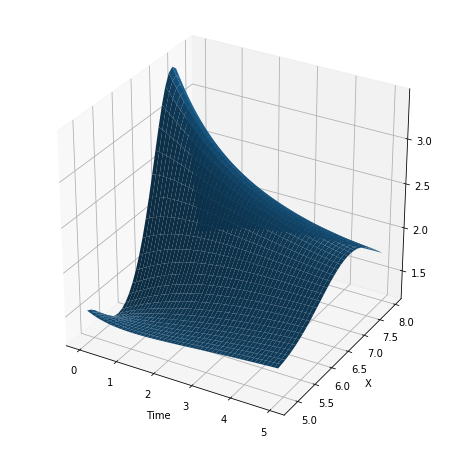

In [332]:
u = data_model.visualize(13,subset=True)

## Burger's Equation

In [6]:
class BurgersEqn(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,dt,dx,viscosity,batch_size,acc_order=2,time_scheme='rk4'):
        Nx = 128
        super(BurgersEqn,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.viscosity = viscosity
        self.acc_order = acc_order
        self.batch_size = batch_size
        self._data = self._generateData()   
    
        
    def _generateData(self):
        start = 48
        end = 80
        self.x,self.t =  self._getMeshPoints()
        u0 = self._ITrigno() #batch_size x 1 x X_dim
        u0[...,0] = u0[...,-1] = 0
        u = []   
        u_whole = []
        ut = torch.from_numpy(u0)
        u_whole.append(torch.from_numpy(u0))
        u.append(torch.from_numpy(u0[...,start:end]))
        for i in range(1,self.Nt):
            u_next = self.step(ut)
            #boundary condtion
            u_next[...,0] = 0
            u_next[...,-1] = 0
            ut = u_next
            u.append(u_next[...,start:end])
            u_whole.append(u_next)
            
        self.u_all = u_whole
        return u
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    def _ITrigno(self):
        batch_size = self.batch_size
        w0 = 0.0
        c = np.random.uniform(-2,2,(batch_size,1))
        for k in range(-4,5):
            mew_k = np.random.normal(0,1,(batch_size,1))
            lambda_k = np.random.normal(0,1,(batch_size,1))
            w0 += mew_k*np.sin(k*self.x) + lambda_k*np.cos(k*self.x)

        I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
        return I[:,np.newaxis,:]
    
    def data(self,step_num):
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, ut):
            ## should calculate the rhs a*d2u/dx2
            #1st order
            kernel_or1 = getKernelTorch(1,self.acc_order)
            ut_padded_or1 = padInputTorch(ut,1,self.acc_order)
            ux_t = F.conv1d(ut_padded_or1,kernel_or1)/self.dx     
            #2nd order 
            kernel_or2 = getKernelTorch(2,self.acc_order)
            ut_padded_or2 = padInputTorch(ut,2,self.acc_order)
            uxx_t = F.conv1d(ut_padded_or2,kernel_or2)/self.dx**2
            
            return self.viscosity*uxx_t - ut*ux_t

        
    def visualize(self,b,subset=True):
        #displays ith batch plot
        ##time x batch_size x 1 x x_dim 
        u = []
        disp_arr = self.u_all
        x = self.x
        if subset:
            disp_arr = self._data
            x = self.x[48:80]
            
        for i in range(len(self._data)):
            u.append(np.array(disp_arr[i][b]).reshape(-1))
        u = np.array(u)
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, u)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.show()
        
        return u

In [34]:
data_model_burgers = BurgersEqnTrign("burgers",nt,dt,dx,D,batch_size=2)

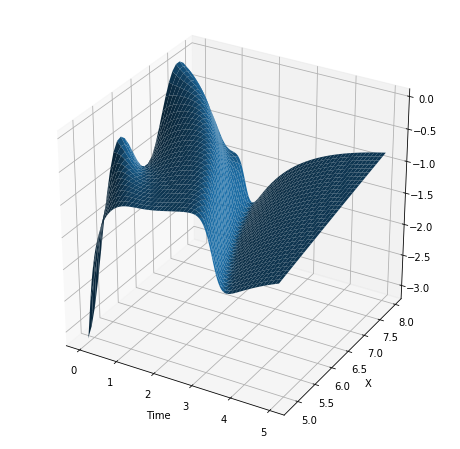

array([[-3.15254935, -3.00411055, -2.73868844, ..., -0.2623866 ,
        -0.41782701, -0.57065298],
       [-3.13156313, -2.96656869, -2.69181116, ..., -0.26504718,
        -0.42092886, -0.5740619 ],
       [-3.10809843, -2.92800344, -2.64550379, ..., -0.26774056,
        -0.42405581, -0.57748634],
       ...,
       [-1.37212855, -1.3536924 , -1.33528526, ..., -0.85687566,
        -0.84000309, -0.82318548],
       [-1.37086535, -1.35244821, -1.33406018, ..., -0.85615508,
        -0.83929898, -0.82249754],
       [-1.36960462, -1.35120645, -1.3328375 , ..., -0.8554358 ,
        -0.83859612, -0.82181082]])

In [38]:
data_model_burgers.visualize(1,subset=True)

## Cross-advection (2 channels)

In [7]:
##generates 128x128 and takes 32x32
## this is to test 2 channels
class CrossAdvection(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,dt,dx,viscosity,batch_size,acc_order=2,time_scheme='rk4'):
        Nx = 128
        super(CrossAdvection,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.viscosity = viscosity
        self.acc_order = acc_order
        self.batch_size = batch_size
        self._data = self._generateData()   
    
        
    def _generateData(self):
        start = 48
        end = 80
        self.x,self.t =  self._getMeshPoints()
        u0 = self._ITrigno() #batch_size x 1 x X_dim # for u dimension
        v0 = self._ITrigno() #batch_size x 1 x X_dim # for v dimension
        
        u0[...,0] = u0[...,-1] = 0
        v0[...,0] = v0[...,-1] = 0
        
        #capital U denotes the u and v both
        U0 = np.concatenate((u0,v0),axis=1) ## batch_size x 2 x X_dim

        U = []
        U_whole = []
        
        Ut = torch.from_numpy(U0)
        U_whole.append(Ut)       
        U.append(torch.from_numpy(U0[...,start:end]))

        for i in range(1,self.Nt):
            U_next = self.step(Ut)
            #boundary condtion
            U_next[...,0] = 0
            U_next[...,-1] = 0
            Ut = U_next
            U.append(U_next[...,start:end])
            U_whole.append(U_next)
            
        self.U_all = U_whole
        return U
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    def _ITrigno(self):
        batch_size = self.batch_size
        w0 = 0.0
        c = np.random.uniform(-2,2,(batch_size,1))
        for k in range(-4,5):
            mew_k = np.random.normal(0,1,(batch_size,1))
            lambda_k = np.random.normal(0,1,(batch_size,1))
            w0 += mew_k*np.sin(k*self.x) + lambda_k*np.cos(k*self.x)

        I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
        return I[:,np.newaxis,:]
    
    def data(self,step_num):
        '''
            returns of shape batch_size X 2 X X_dim
        '''
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, Ut):
            #1st order
            U_split = Ut.split(1,dim=1)
            U_next = []
            
            kernel_or1 = getKernelTorch(1,self.acc_order)
            kernel_or2 = getKernelTorch(2,self.acc_order)
            for i in range(2):
                Ut_padded_or1 = padInputTorch(U_split[i],1,self.acc_order)
                Ux_t = F.conv1d(Ut_padded_or1,kernel_or1)/self.dx     
                #2nd order 
                Ut_padded_or2 = padInputTorch(U_split[i],2,self.acc_order)
                Uxx_t = F.conv1d(Ut_padded_or2,kernel_or2)/self.dx**2
                
                U_next.append(self.viscosity*Uxx_t - U_split[(i+1)%2]*Ux_t)
                
            U_next = torch.cat(U_next,dim=1)
            return U_next

        
    def visualize(self,b,subset=True):
        #displays ith batch plot
        ##time x batch_size x 1 x x_dim 
        u = []
        v = []
        disp_arr = self.U_all
        x = self.x
        if subset:
            disp_arr = self._data
            x = self.x[48:80]
            
        for i in range(len(self._data)):
            u.append(np.array(disp_arr[i][b][0]).reshape(-1))
            v.append(np.array(disp_arr[i][b][1]).reshape(-1))
            
        u = np.array(u)
        v = np.array(v)
        
        
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, u)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.title("u")
        plt.show()
        
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, v)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.title("v")
        plt.show()
        


In [340]:
data_model = CrossAdvection("Advection",nt,dt,dx,D,batch_size=32)

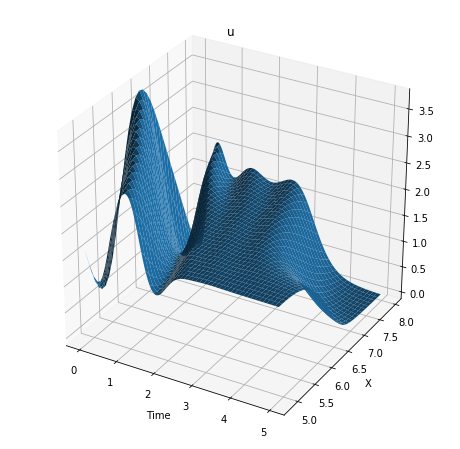

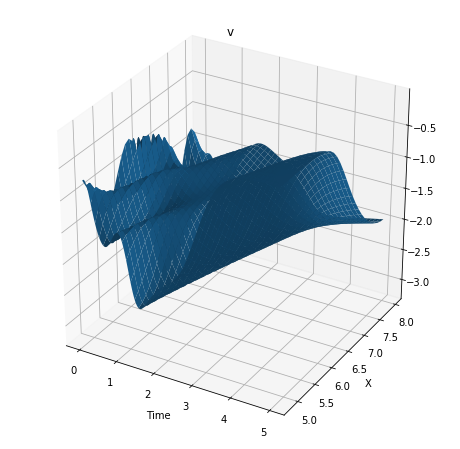

In [341]:
data_model.visualize(1)

## Energy Exchange

In [287]:
nx = 50 
nt = 1000
dx = 1
dt = 0.1
D = 0.1 #diffusion coeff
sigma = 0.05

In [15]:
D = 0.1

In [8]:
##generates 128x128 and takes 32x32
## this is to test 2 channels
class EnergyExchange(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,dt,dx,viscosity,batch_size,acc_order=2,time_scheme='rk4'):
        Nx = 128
        super(EnergyExchange,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.viscosity = viscosity
        self.acc_order = acc_order
        self.batch_size = batch_size
        self._data = self._generateData()   
    
        
    def _generateData(self):
        start = 48
        end = 80
        self.x,self.t =  self._getMeshPoints()
        u0 = self._ITrigno() #batch_size x 1 x X_dim # for u dimension
        v0 = self._ITrigno() #batch_size x 1 x X_dim # for v dimension
        
        u0[...,0] = u0[...,-1] = 0
        v0[...,0] = v0[...,-1] = 0
        
        #capital U denotes the u and v both
        U0 = np.concatenate((u0,v0),axis=1) ## batch_size x 2 x X_dim

        U = []
        U_whole = []
        
        Ut = torch.from_numpy(U0)
        U_whole.append(Ut)       
        U.append(torch.from_numpy(U0[...,start:end]))

        for i in range(1,self.Nt):
            U_next = self.step(Ut)
            #boundary condtion
            
            U_next[...,0] = 0
            U_next[...,-1] = 0
            Ut = U_next
            U.append(U_next[...,start:end])
            U_whole.append(U_next)
            
        self.U_all = U_whole
        return U
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    def _ITrigno(self):
        batch_size = self.batch_size
        w0 = 0.0
        c = np.random.uniform(-2,2,(batch_size,1))
        for k in range(-4,5):
            mew_k = np.random.normal(0,1,(batch_size,1))
            lambda_k = np.random.normal(0,1,(batch_size,1))
            w0 += mew_k*np.sin(k*self.x) + lambda_k*np.cos(k*self.x)

        I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
        return I[:,np.newaxis,:]
    
    def data(self,step_num):
        '''
            returns of shape step_num x batch_size X 2 X X_dim
        '''
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, Ut):
            #1st order
            U_split = Ut.split(1,dim=1)
            U_next = []
            kernel_or1 = getKernelTorch(1,self.acc_order)
            kernel_or2 = getKernelTorch(2,self.acc_order)
            
            #du/dx
            Ut_padded_or1 = padInputTorch(U_split[0],1,self.acc_order)
            
            
            Ux_t = F.conv1d(Ut_padded_or1,kernel_or1)/self.dx  
            #dv/dx
            Vt_padded_or1 = padInputTorch(U_split[1],1,self.acc_order)
            Vx_t = F.conv1d(Vt_padded_or1,kernel_or1)/self.dx  
            
            for i in range(2):
                #2nd order 
                Ut_padded_or2 = padInputTorch(U_split[i],2,self.acc_order)
                Uxx_t = F.conv1d(Ut_padded_or2,kernel_or2)/self.dx**2                
                U_next.append(self.viscosity*Uxx_t + ((-1)**(i+1))*U_split[0]*U_split[1])
                
            U_next = torch.cat(U_next,dim=1)
            return U_next

        
    def visualize(self,b,subset=True):
        #displays ith batch plot
        ##time x batch_size x 1 x x_dim 
        u = []
        v = []
        disp_arr = self.U_all
        x = self.x
        if subset:
            disp_arr = self._data
            x = self.x[48:80]
            
        for i in range(len(self._data)):
            u.append(np.array(disp_arr[i][b][0]).reshape(-1))
            v.append(np.array(disp_arr[i][b][1]).reshape(-1))
            
        u = np.array(u)
        v = np.array(v)
        
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, u)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.title("u")
        plt.show()
        
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, v)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.title("v")
        plt.show()
        


In [81]:
data_model = EnergyExchange("energy",1000,0.0001,0.1,D,batch_size=32,time_scheme='rk4')

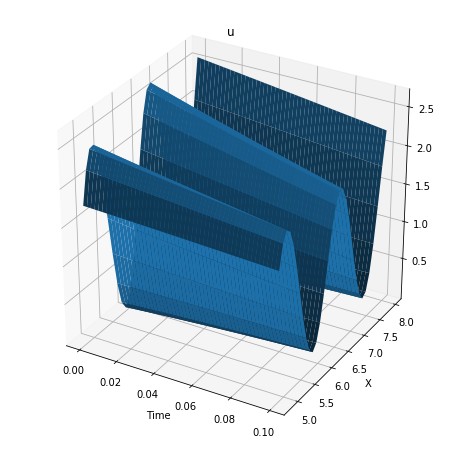

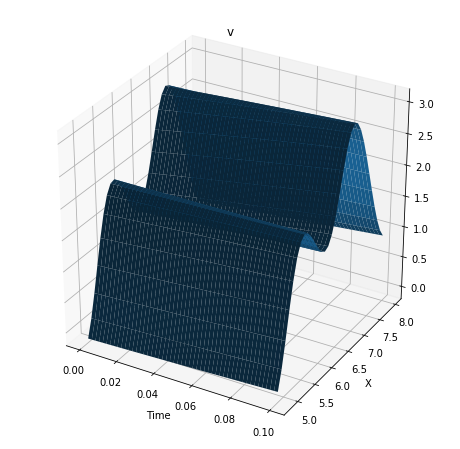

In [82]:
data_model.visualize(4)

## Energy Exchange Advanced

In [9]:
##generates 128x128 and takes 32x32
## this is to test 2 channels
class EnergyExchangeAdvan(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,dt,dx,viscosity,batch_size,acc_order=2,time_scheme='rk4'):

        Nx = 128
        super(EnergyExchangeAdvan,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.viscosity = viscosity
        self.acc_order = acc_order
        self.batch_size = batch_size
        self._data = self._generateData()   
    
        
    def _generateData(self):
        start = 48
        end = 80
        self.x,self.t =  self._getMeshPoints()
        u0 = self._ITrigno() #batch_size x 1 x X_dim # for u dimension
        v0 = self._ITrigno() #batch_size x 1 x X_dim # for v dimension
        
        u0[...,0] = u0[...,-1] = 0
        v0[...,0] = v0[...,-1] = 0
        
        #capital U denotes the u and v both
        U0 = np.concatenate((u0,v0),axis=1) ## batch_size x 2 x X_dim
        U = []
        U_whole = []
        
        Ut = torch.from_numpy(U0)
        U_whole.append(Ut)       
        U.append(torch.from_numpy(U0[...,start:end]))

        for i in range(1,self.Nt):
            U_next = self.step(Ut)
            #boundary condtion
            
            U_next[...,0] = 0
            U_next[...,-1] = 0
            Ut = U_next
            U.append(U_next[...,start:end])
            U_whole.append(U_next)
            
        self.U_all = U_whole
        return U
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    def _ITrigno(self):
        batch_size = self.batch_size
        w0 = 0.0
        c = np.random.uniform(-2,2,(batch_size,1))
        for k in range(-4,5):
            mew_k = np.random.normal(0,1,(batch_size,1))
            lambda_k = np.random.normal(0,1,(batch_size,1))
            w0 += mew_k*np.sin(k*self.x) + lambda_k*np.cos(k*self.x)

        I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
        return I[:,np.newaxis,:]
    
    def data(self,step_num):
        '''
            returns of shape step_num X batch_size X 2 X X_dim
        '''
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, Ut):
            #1st order
            U_split = Ut.split(1,dim=1)
            U_next = []
            kernel_or1 = getKernelTorch(1,self.acc_order)
            kernel_or2 = getKernelTorch(2,self.acc_order)
            
            #du/dx
            Ut_padded_or1 = padInputTorch(U_split[0],1,self.acc_order)
            
            
            Ux_t = F.conv1d(Ut_padded_or1,kernel_or1)/self.dx  
            #dv/dx
            Vt_padded_or1 = padInputTorch(U_split[1],1,self.acc_order)
            Vx_t = F.conv1d(Vt_padded_or1,kernel_or1)/self.dx  
            
            for i in range(2):
                #2nd order 
                Ut_padded_or2 = padInputTorch(U_split[i],2,self.acc_order)
                Uxx_t = F.conv1d(Ut_padded_or2,kernel_or2)/self.dx**2                
                
                U_next.append(self.viscosity*Uxx_t + ((-1)**(i+1))*Ux_t*Vx_t)
                
            U_next = torch.cat(U_next,dim=1)

            return U_next

        
    def visualize(self,b,subset=True):
        #displays ith batch plot
        ##time x batch_size x 1 x x_dim 
        u = []
        v = []
        disp_arr = self.U_all
        x = self.x
        if subset:
            disp_arr = self._data
            x = self.x[48:80]
            
        for i in range(len(self._data)):
            u.append(np.array(disp_arr[i][b][0]).reshape(-1))
            v.append(np.array(disp_arr[i][b][1]).reshape(-1))
            
        u = np.array(u)
        v = np.array(v)
        
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, u)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.title("u")
        plt.show()
        
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, v)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.title("v")
        plt.show()
        


In [87]:
data_model = EnergyExchangeAdvan("energy_advanced",500,0.0001,0.1,D,batch_size=32,time_scheme='rk4')

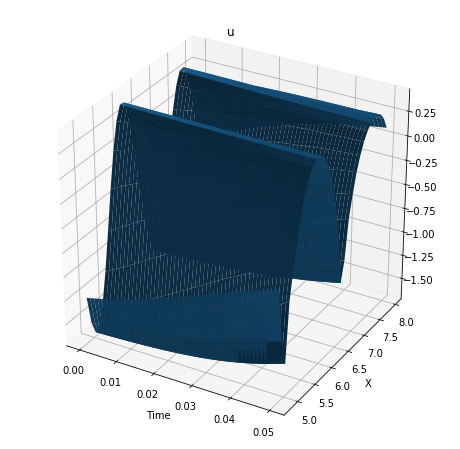

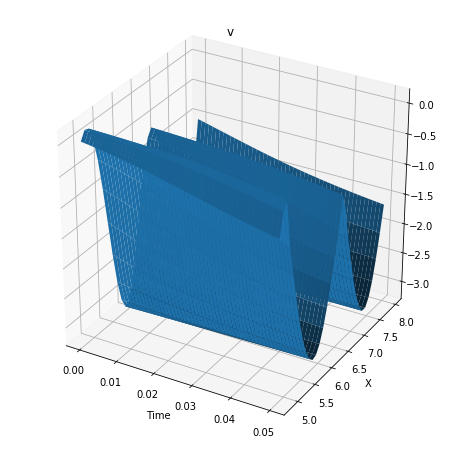

In [88]:
data_model.visualize(1)